In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.widgets import RectangleSelector
from tabulate import tabulate
from sklearn.cluster import DBSCAN
import tkinter.filedialog as tkf
from scipy import optimize
import ipywidgets as pyw

In [2]:
# refer to https://scipy-cookbook.readthedocs.io/items/FittingData.html

def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape) # row, col
    x = (X*data).sum()/total # row
    y = (Y*data).sum()/total # col
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum()) # row
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum()) # col
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [3]:
def gaussian_center(image, cbox_edge=0):
    y, x = np.indices(image.shape)
    if not cbox_edge:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    else:
        cbox_outy = int(image.shape[0]/2 - cbox_edge/2)
        cbox_outx = int(image.shape[1]/2 - cbox_edge/2)
        center_box = image[cbox_outy:-cbox_outy, cbox_outx:-cbox_outx]
        fit_params = fitgaussian(center_box)
        (_, center_y, center_x, _, _) = fit_params
        center = [center_y+cbox_outy, center_x+cbox_outx]
        
    return center

In [4]:
def remove_center_beam(image, center=None, cb_rad=0):
    y, x = np.indices(image.shape)
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    r = np.hypot(y - center[0], x - center[1])
    r = np.around(r)
    ri = np.where(r<=cb_rad)
    #print(ri[0].shape)
    
    image[ri] = 0
    
    return image

In [5]:
# refer to github.com/mkolopanis/python/blob/master/radialProfile.py

def radial_variance(image, profile_resolution=1.0, center=None):
   
    y, x = np.indices(image.shape) * profile_resolution
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    r = np.hypot(y - center[0]*profile_resolution, x - center[1]*profile_resolution)
    #plt.imshow(r, cmap="Accent")
    #plt.show()

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = np.around(r_sorted)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    csim = np.cumsum(i_sorted, dtype=float)
    sq_csim = np.cumsum(np.square(i_sorted), dtype=float)
    
    #plt.plot(np.square(csim), c="red")
    #plt.plot(sq_csim, c="blue")
    
    avg_square = np.square((csim[rind[1:]] - csim[rind[:-1]]) / nr)
    square_avg = (sq_csim[rind[1:]] - sq_csim[rind[:-1]]) / nr
    
    #plt.plot(avg_square[20:], c="red")
    #plt.plot(square_avg[20:], c="blue")
    
    mask = avg_square.copy()
    mask[np.where(avg_square==0)] = 1.0
    radial_var = (square_avg - avg_square) / mask
    
    return radial_var    

In [6]:
def load_binary_4D_stack(img_adr, datatype, original_shape, final_shape, log_scale=False):
    raw_stack = np.fromfile(img_adr, dtype=datatype)
    stack = raw_stack.reshape(original_shape)
    print(stack.shape)
    if log_scale:
        stack = np.log(stack[:final_shape[0], :final_shape[1], :final_shape[2], :final_shape[3]])
    else:
        stack = stack[:final_shape[0], :final_shape[1], :final_shape[2], :final_shape[3]]
    
    print(stack.shape) 
    return stack

In [7]:
raw_adr = tkf.askopenfilename()
print(raw_adr)

G:/내 드라이브/data_repository/4D/20190925_DGIST/raw_data/Bset3_3/scan_x256_y256.raw


In [8]:
datatype = "float32"
o_shape = (256, 256, 130, 128)
f_shape = (256, 256, 128, 128)

In [9]:
# load a data
stack_4d = load_binary_4D_stack(raw_adr, datatype, o_shape, f_shape, log_scale=False)
print(np.max(stack_4d))
print(np.min(stack_4d))
print(np.mean(stack_4d))
#print(np.median(stack_4d))

(256, 256, 130, 128)
(256, 256, 128, 128)
1121295.0
1170.0
5460.203


In [10]:
# select an interesting area
%matplotlib qt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.sum(stack_4d, axis=(2, 3)), cmap="gray")

def onselect(eclick, erelease):
    print('startposition: (%f, %f)' % (eclick.xdata, eclick.ydata))
    print('endposition  : (%f, %f)' % (erelease.xdata, erelease.ydata))

box = RectangleSelector(ax, onselect)
plt.show()

startposition: (95.717568, 87.066424)
endposition  : (157.618430, 148.967285)


In [11]:
# crop the data
stack_4d_cropped = stack_4d[int(box.corners[1][0]):int(box.corners[1][2]), 
                                           int(box.corners[0][0]):int(box.corners[0][1])].copy()
print(stack_4d_cropped.shape)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
#print(np.median(stack_4d_cropped))

(61, 62, 128, 128)
432495.0
1210.0
4450.9634


In [12]:
%matplotlib inline

(61, 62, 2)
[64.4653392  65.11714673]


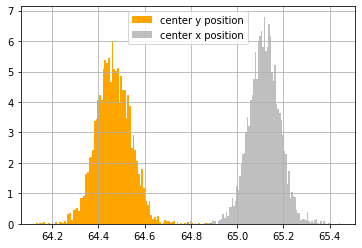

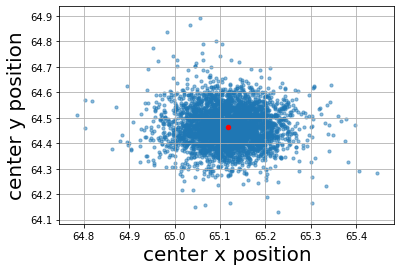

In [13]:
# find center position
center_pos = []
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        center_pos.append(gaussian_center(stack_4d_cropped[i, j], cbox_edge=30))
        
center_pos = np.asarray(center_pos)
center_pos = np.reshape(center_pos, (stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1))
print(center_pos.shape)
center_mean = np.mean(center_pos, axis=(0, 1))
print(center_mean)

# center distibution
plt.figure()
plt.hist(center_pos[:, :, 0].flatten(), bins=100, density=True, color="orange", label="center y position")
plt.hist(center_pos[:, :, 1].flatten(), bins=100, density=True, color="gray", alpha=0.5, label="center x position")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.scatter(center_pos[:, :, 1], center_pos[:, :, 0], s=10.0, alpha=0.5)
plt.grid()
plt.scatter(center_mean[1], center_mean[0], s=20, c="red")
plt.xlabel("center x position", fontsize=20)
plt.ylabel("center y position", fontsize=20)
plt.show()

In [14]:
# remove center beam
stack_4d_cropped_cb = stack_4d_cropped.copy()
center_radius = 20
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
#print(np.median(stack_4d_cropped))

29347.0
0.0
2815.8618


(61, 62, 91)
(91,)


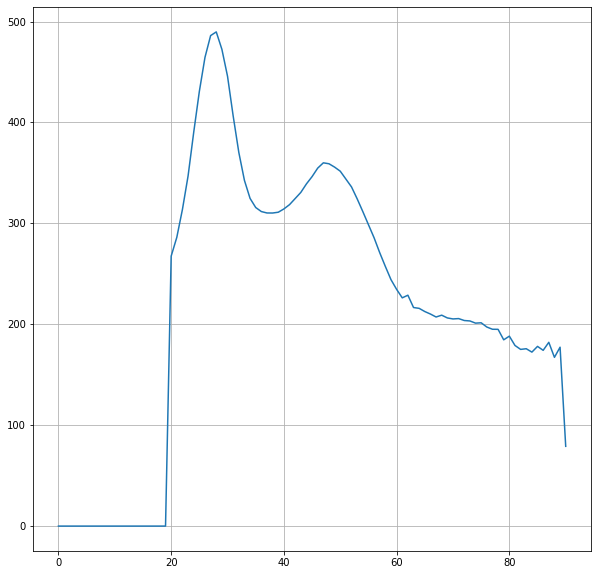

In [15]:
# calculate variance with all angles at a certain k
radial_var_stack = []
len_profile = []
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        radial_temp = radial_variance(stack_4d_cropped[i, j], center=center_mean.tolist())
        len_profile.append(len(radial_temp))
        radial_var_stack.append(radial_temp)

if len(np.unique(len_profile)) > 1:
    print(np.unique(len_profile))
    shortest = np.min(len_profile)
    for i in range(len(len_profile)):
        radial_var_stack[i] = radial_var_stack[i][:shortest]

radial_var_stack = np.asarray(radial_var_stack).reshape(stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1)
print(radial_var_stack.shape)

radial_var_sum = np.sum(radial_var_stack, axis=(0, 1))
print(radial_var_sum.shape)

plt.figure(figsize=(10,10))
plt.plot(radial_var_sum)
plt.grid()
plt.show()

In [ ]:
%matplotlib inline

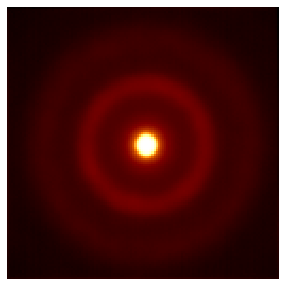

In [16]:
radii = np.arange(len(radial_var_sum))
#pacbed = np.mean(stack_4d_cropped, axis=(0, 1))
pacbed = np.log(np.mean(stack_4d_cropped_cb, axis=(0, 1)))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(pacbed, cmap="afmhot")
ax.axis("off")
plt.show()

In [17]:
k1 = 27
k2 = 29
p1 = 90.0
p2 = 99.9
v1 = np.percentile(radial_var_stack[:, :, k1:(k2+1)], p1)
v2 = np.percentile(radial_var_stack[:, :, k1:(k2+1)], p2)

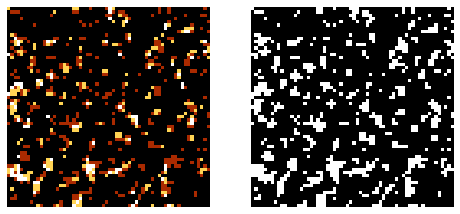

In [19]:
masked = radial_var_stack[:, :, k1:(k2+1)].copy()
img_tmp = np.ones_like(masked)
img_tmp[np.where(masked < v1)] = 0
img_tmp[np.where(masked > v2)] = 0
img = np.sum(img_tmp, axis=2)
bool_img = np.zeros_like(img)
bool_img[np.where(img != 0)] = 1

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img, cmap="afmhot")
ax[0].axis("off")
ax[1].imshow(bool_img, cmap="afmhot")
ax[1].axis("off")
plt.show()

number of clusters = 56
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]


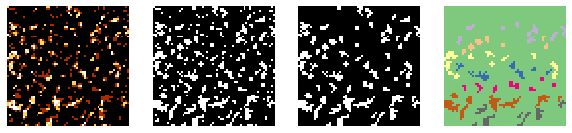

In [36]:
min_num = 4
epsilon = 2**(1/2)
db = DBSCAN(eps=epsilon, min_samples=min_num)
sel_coor = np.nonzero(bool_img)
X = np.stack((sel_coor[0], sel_coor[1]), axis=1)
db.fit(X)
img_tmp = np.zeros_like(bool_img)
img_tmp += -1
img_tmp[X[:, 0], X[:, 1]] = db.labels_
labeled_cluster_img = img_tmp.copy()
cluster_img = np.where(img_tmp<0, img_tmp, 1)
cluster_img = np.where(cluster_img>-1, bool_img, 0)

label = np.unique(db.labels_)[1:]
print("number of clusters = %d"%(len(label)))
print(label)

fig, ax = plt.subplots(1, 4, figsize=(10, 4))
ax[0].imshow(img, cmap="afmhot")
ax[0].axis("off")
ax[1].imshow(bool_img, cmap="afmhot")
ax[1].axis("off")
ax[2].imshow(cluster_img, cmap="afmhot")
ax[2].axis("off")
ax[3].imshow(labeled_cluster_img, cmap="Accent")
ax[3].axis("off")
plt.show()